# Forecasting Hotel Booking Cancellations.

The hospitality industry thrives in tourist hotspots, but one of the significant challenges it faces is booking cancellations. Last-minute or unexpected cancellations can result in substantial revenue losses for hotels. When a booking is canceled, the hotel not only loses the expected income but also misses the opportunity to rebook the room for the same period.

Accurately predicting the likelihood of a booking cancellation in advance can help hotel owners mitigate these losses. 
#### The aim of this project is to forecast room cancellations using historical booking data with the highest possible accuracy

### Importing necessary libraries

In [622]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

import warnings
warnings.filterwarnings('ignore')

### Getting the data

In [623]:
df = pd.read_csv("/kaggle/input/hotel-booking-demand/hotel_bookings.csv")

In [624]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

- There are 119390 records in total and 32 columns.
- There are missing values in a few columns

### Exploratory Data Analysis and Data Pre-processing

In [626]:
df.isnull().sum()/len(df) * 100

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

There is only one column that has more than 90% null values. This column can be dropped.

In [627]:
#Dropping column with more than 90% missing value
df = df.drop(columns = ["company"])

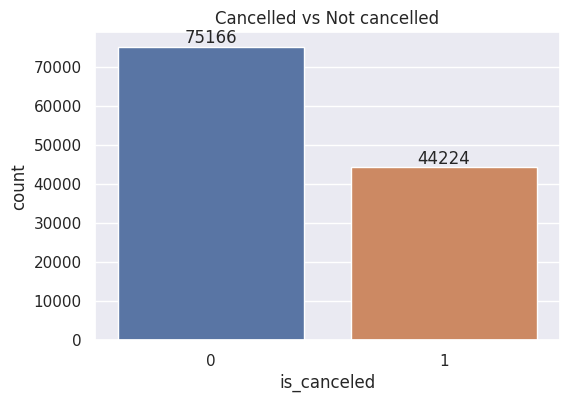

In [628]:
# Distribution of target column
plt.figure(figsize=(6,4))

ax = sns.countplot(x=df["is_canceled"])
for i in ax.containers:
    ax.bar_label(i)
ax.set(title="Cancelled vs Not cancelled")
plt.show()

- Out of all records, 44224 rooms have been cancelled ,i.e., 37%


In the fields present, there are children and babies. Both can be combined into a single column and the redundancy can be dropped.

In [629]:
df["kids"]=df["children"]+df["babies"]

In [630]:
df = df.drop(columns = ["children", "babies"])

In [631]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
is_repeated_guest,119390.0,0.031912,0.175767,0.00,0.00,0.000,0.0,1.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0


In the above cell, we can see some odd values in a few columns.


#### Stays in weekend nights and weeknights minimum value is 0. If both are 0 in the same row, it is unrealistic. We will check for these records and drop them

In [632]:
stays = df[(df["stays_in_weekend_nights"]==0) & (df["stays_in_week_nights"]==0)]

In [633]:
stays["is_canceled"].value_counts()

is_canceled
0    680
1     35
Name: count, dtype: int64

Here, we see that rooms were reserved and very few cancellations are present for the records but the stays are 0.

We will drop these unrealistic records

In [634]:
#Dropping records where stays in weekend nights and also weekday nights are 0
row_index=0

for i in df["stays_in_weekend_nights"]:
    if i==0 and df["stays_in_week_nights"][row_index]==0:
        df = df.drop(row_index) 
       
    row_index=row_index+1

In [635]:
df = df.reset_index()
df = df.drop(columns=["index"])


#### Kids and Adults

There is also possibility of erroneous records where the bookings are done only with kids and no adults. We will filter out if there are any.

In [636]:
only_kids = df[(df["adults"]==0) & (df["kids"]!=0)]

In [637]:
only_kids

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,kids
40598,City Hotel,0,1,2015,August,33,10,1,1,0,...,No Deposit,NaN,0,Transient-Party,9.00,0,0,Check-Out,2015-08-12,3.0
40661,City Hotel,0,104,2015,August,33,11,0,3,0,...,No Deposit,7.0,0,Transient-Party,6.00,0,2,Check-Out,2015-08-14,2.0
41058,City Hotel,0,3,2015,August,34,16,2,0,0,...,No Deposit,NaN,0,Transient-Party,6.00,0,1,Check-Out,2015-08-18,2.0
41564,City Hotel,0,15,2015,August,35,28,0,1,0,...,No Deposit,NaN,0,Transient,0.00,0,1,Check-Out,2015-08-29,2.0
44762,City Hotel,1,48,2015,October,43,19,1,3,0,...,No Deposit,13.0,0,Transient-Party,6.00,0,1,Canceled,2015-09-02,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116493,City Hotel,0,296,2017,July,30,27,1,3,0,...,No Deposit,9.0,0,Transient,98.85,0,1,Check-Out,2017-07-31,2.0
116563,City Hotel,0,276,2017,July,31,30,2,1,0,...,No Deposit,9.0,0,Transient,93.64,0,2,Check-Out,2017-08-02,2.0
116592,City Hotel,0,291,2017,July,30,29,2,2,0,...,No Deposit,9.0,0,Transient,98.85,0,1,Check-Out,2017-08-02,2.0
116742,City Hotel,0,159,2017,July,31,31,1,3,0,...,No Deposit,9.0,0,Transient,121.88,0,1,Check-Out,2017-08-04,2.0


- There are 223 rows with records where adults are 0 and kids are more than 0. 
- All the records where the number of adults are 0 are unrealistic and will be dropped.

In [638]:
#Dropping rows where there are no adults
row_index=0
c=0
for i in df["adults"]:
    if i==0:
        df = df.drop(row_index)        
        
    row_index=row_index+1

In [639]:
df = df.reset_index()
df = df.drop(columns=["index"])

#### Looking at values in all the columns

In [640]:
cols = df.columns
for i in cols:
    print(f"-----------------------{i}---------------------------")
    print(f"Values in {i} are {df[i].value_counts()}")
    

-----------------------hotel---------------------------
Values in hotel are hotel
City Hotel      78676
Resort Hotel    39666
Name: count, dtype: int64
-----------------------is_canceled---------------------------
Values in is_canceled are is_canceled
0    74250
1    44092
Name: count, dtype: int64
-----------------------lead_time---------------------------
Values in lead_time are lead_time
0      6001
1      3382
2      2042
3      1801
4      1697
       ... 
387       1
709       1
389       1
380       1
463       1
Name: count, Length: 478, dtype: int64
-----------------------arrival_date_year---------------------------
Values in arrival_date_year are arrival_date_year
2016    56090
2017    40447
2015    21805
Name: count, dtype: int64
-----------------------arrival_date_month---------------------------
Values in arrival_date_month are arrival_date_month
August       13780
July         12553
May          11688
October      11048
April        11024
June         10879
September    1

- Lead time, stays_in_weeknights, stays_in_weekend, waiting list and adr are the only three numerical columns
- Although many other columns have numerical values, they are categorical in nature

In [641]:
#Diving columns into numerical ad categorical 
num_cols = ["lead_time",'stays_in_weekend_nights', 'stays_in_week_nights','days_in_waiting_list','adr']
cat_cols = ['hotel', 'is_canceled', 'arrival_date_year','arrival_date_month', 'arrival_date_day_of_month','adults', 'meal',
       'country', 'market_segment', 'distribution_channel','is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type','assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'customer_type','required_car_parking_spaces', 'total_of_special_requests','reservation_status',
            'reservation_status_date', 'kids']

#### Numerical columns

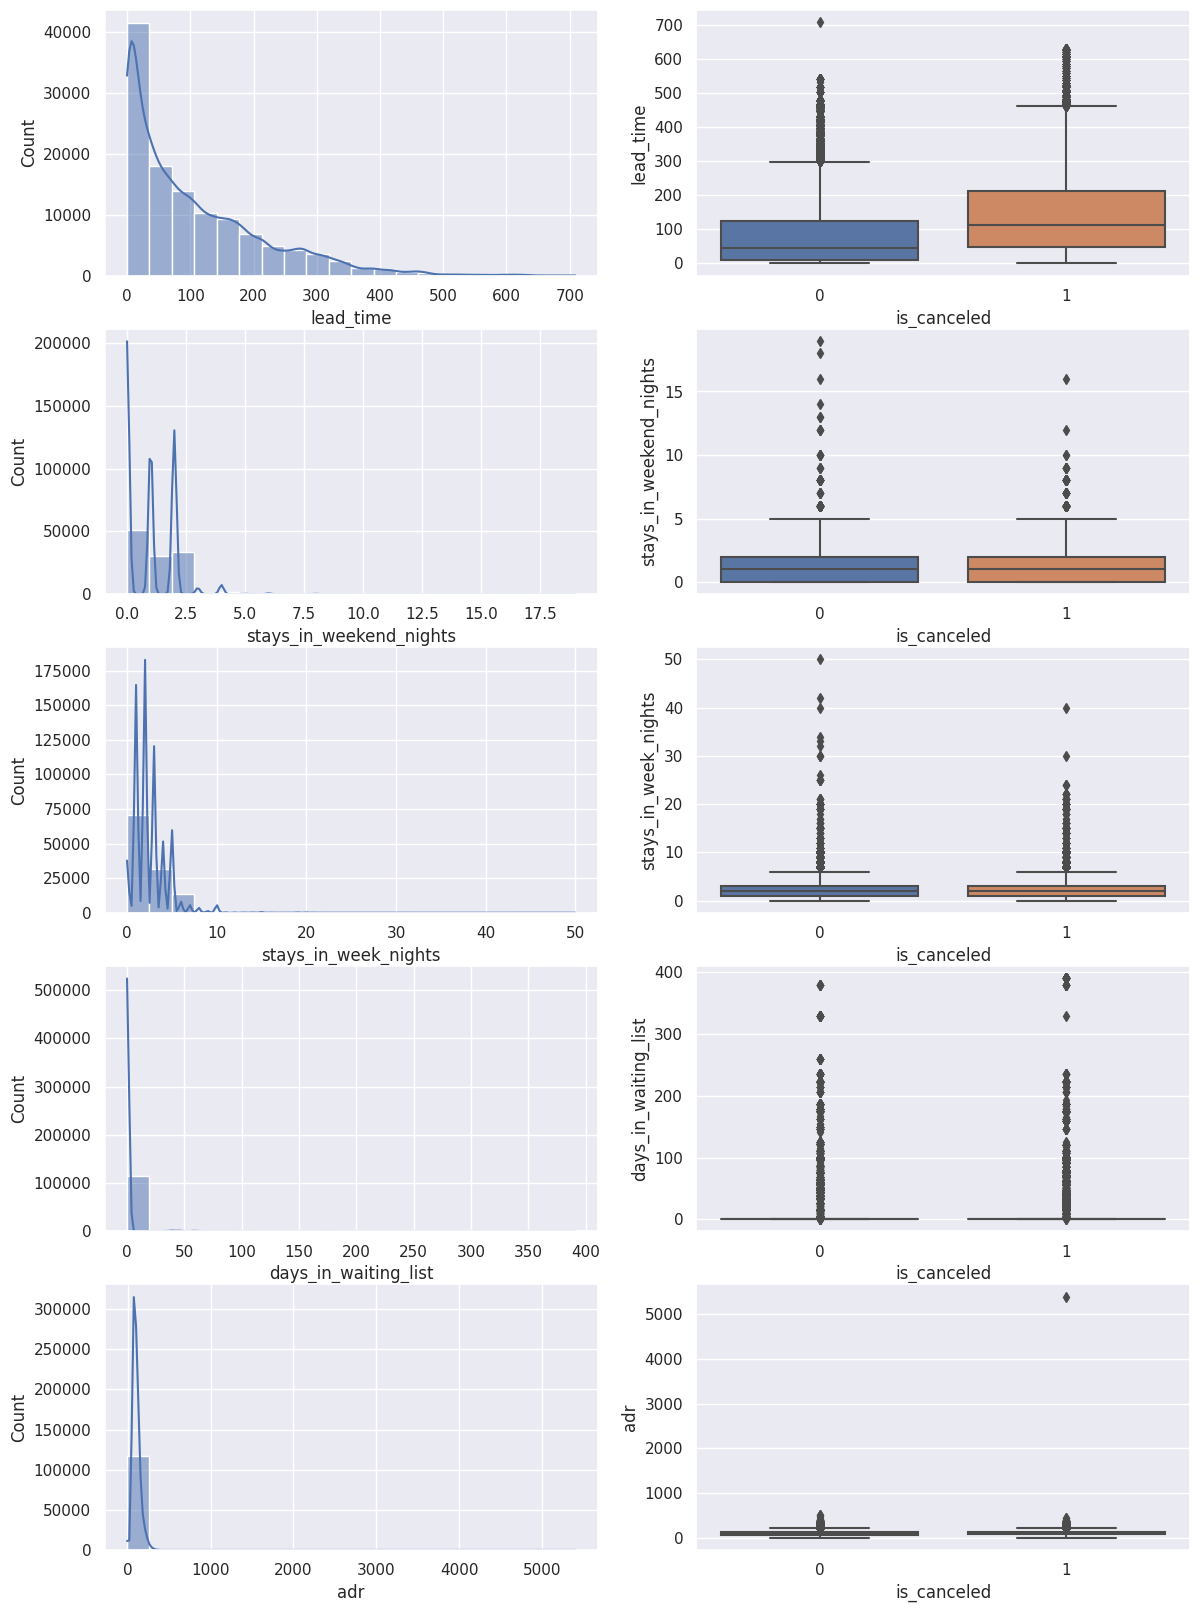

In [642]:
#plotting distribution of numerical columns
r = 5
c = 2
f,axes = plt.subplots(r,c,figsize=(14,20))
ctr = 0
for i in range(r):
    #for j in range(c):
    j=0
    col = num_cols[ctr]
    sns.histplot(x=df[col],bins=20,kde=True,ax=axes[i,j])
    sns.boxplot(x=df["is_canceled"],y=df[col],ax=axes[i,j+1])
    ctr = ctr + 1
plt.show()

- There are significant number of outliers in adr, days in waiting list, stays in weeknights and weekend nights.
- Outliers in waiting list column and adr need to be addressed as they are very high and may significantly impact the outcome.


#### Categorical columns

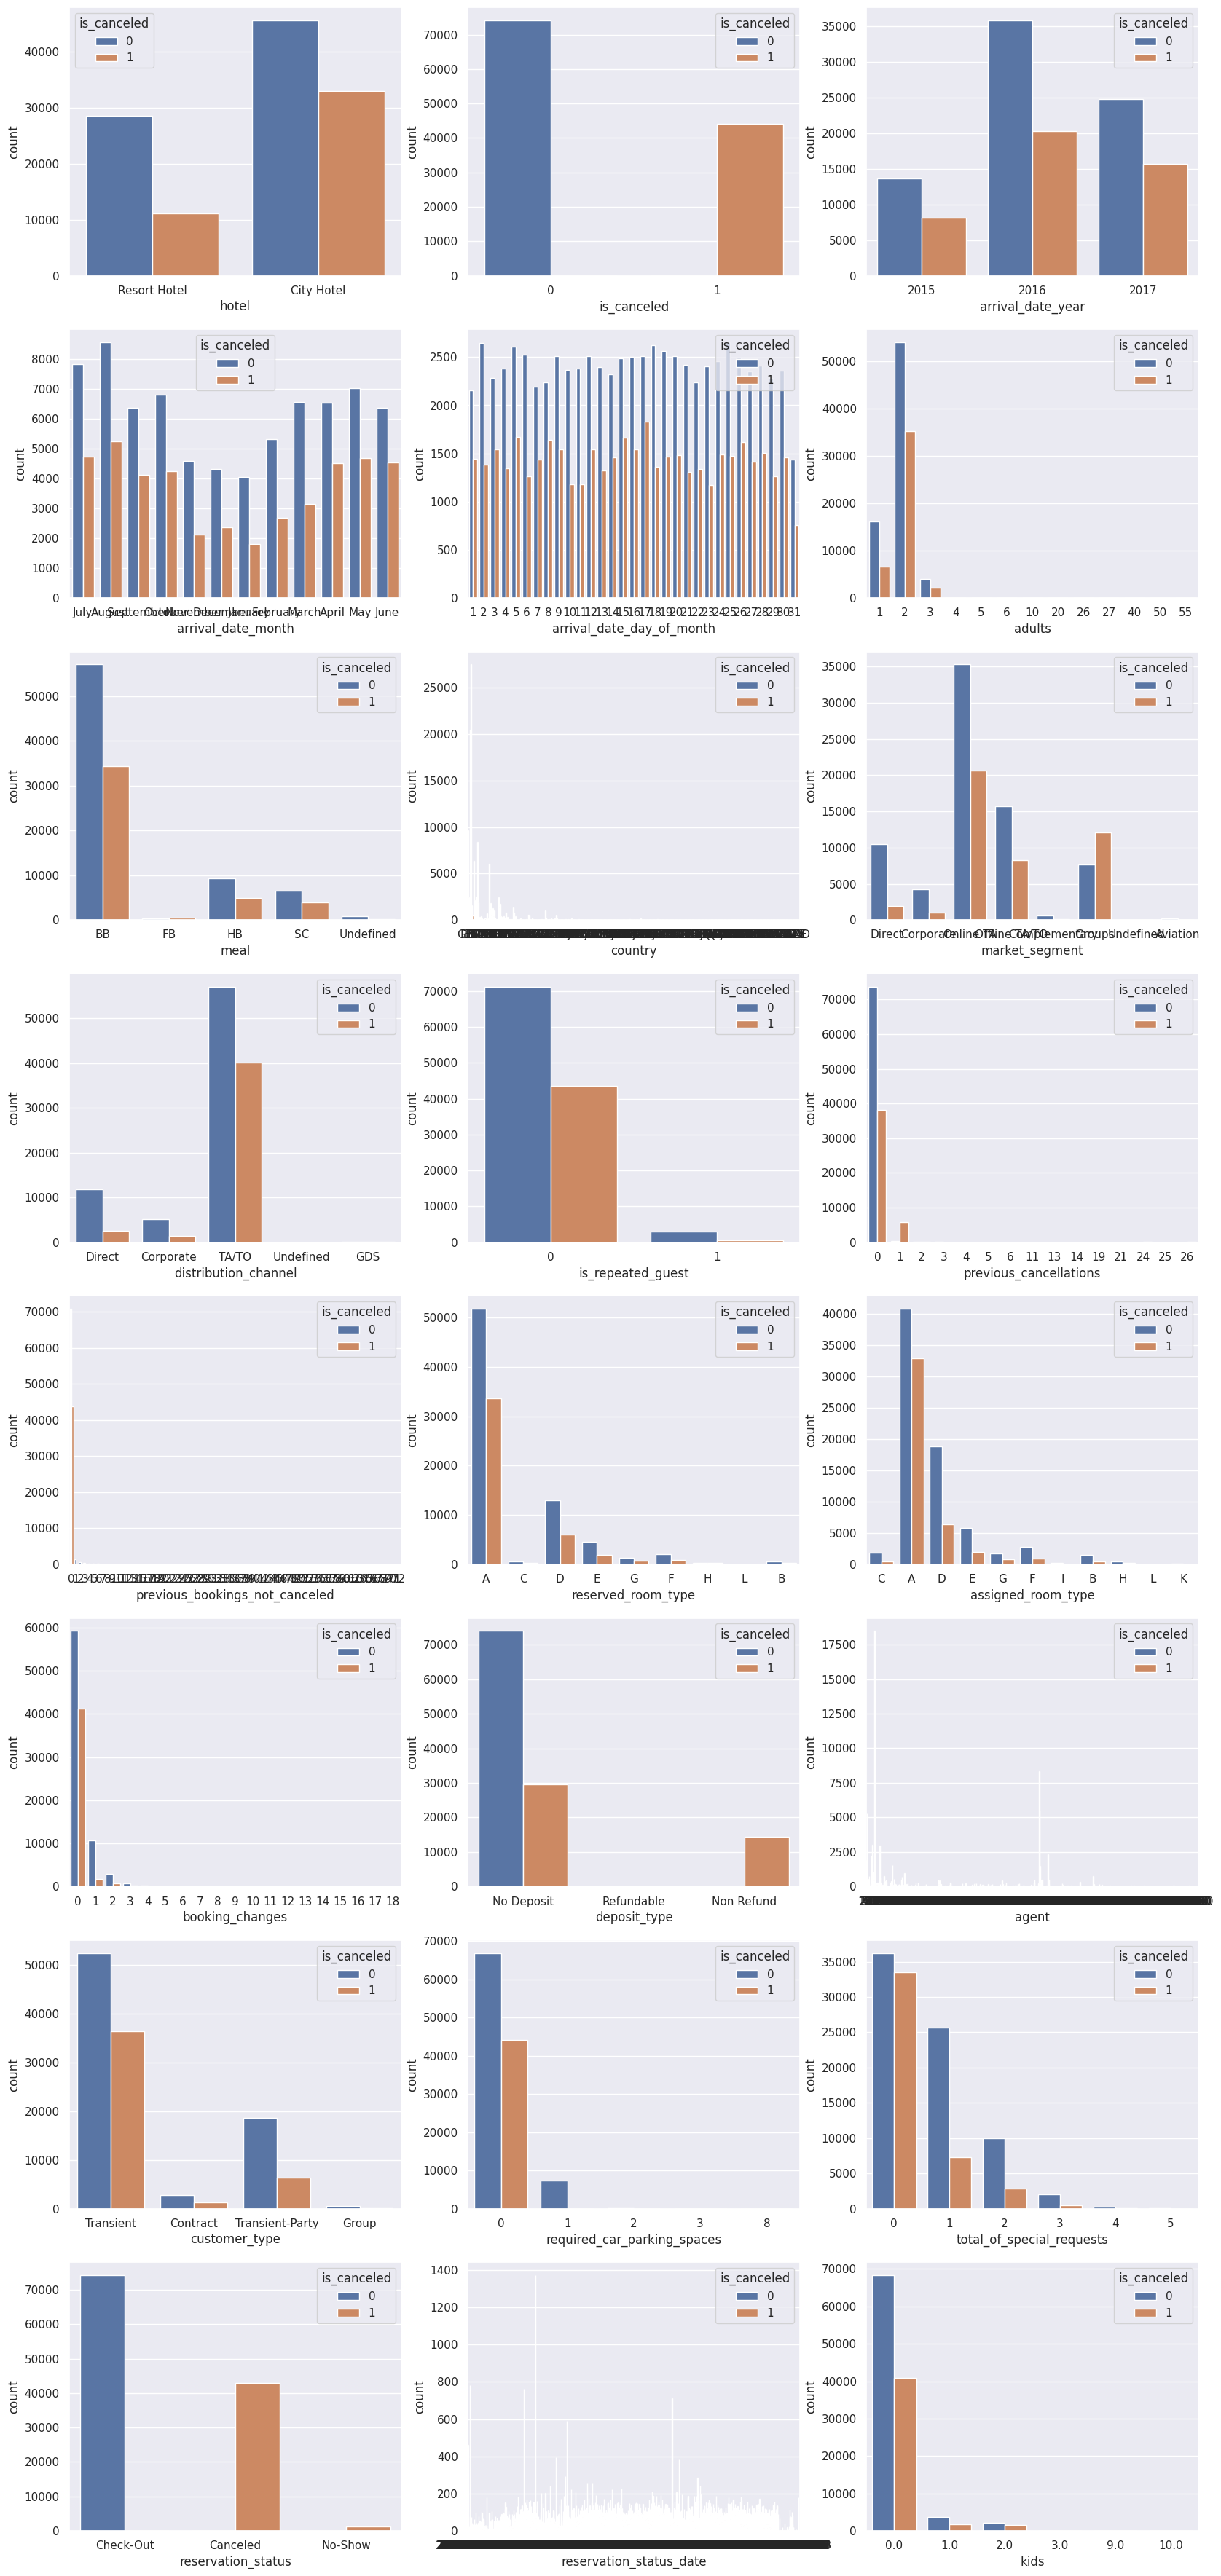

In [643]:
#Plotting distribution of  categorical columns
r = 8
c = 3
f,axes = plt.subplots(r,c,figsize=(20,45))
ctr = 0
for i in range(r):
    for j in range(c):
        col = cat_cols[ctr]
        sns.countplot(x=df[col],hue=df["is_canceled"],ax=axes[i,j])
        
        ctr = ctr + 1
plt.show()

- Bookings and cancellations in a city hotel is higher than resort hotel
- Bookings in year 2016 is highest because of the data distribution. We have data from July 2015 to June 2017.
- There is a significant dip in bookings in November, December and January. As summer in most inhabited continents of the world lasts from May to September, we can assume that for a tourist destination like Portugal, November to January will be a low season and May to September will be high season.
- There is no discernable pattern between day of the month and cancellation.
- The maximum number of bookings seem to be amongst 1 to 3 adults where 2 adults is the highest.
- THere are different types of meals available for the occupants. However, it can be assumed that this will not have impact on the cancellations as there are other more significant factors involved.
- There are total of 177 countries from which tourists are visiting. This needs to be examined further.
- market_segment and distribution_channel are interrelated columns. We can keep market_segment for further exploration.
- is_repeated_guest, previous_cancellations and previous_bookings_not_cancelled data is highly skewed. Needs further exploration before being dropped.
- room A has highest bookings. We must check if cancellations are high where reserved and assigned room types are not same.
- booking_changes also has highly skewed data. 
- Cancellations are high for non-refundable deposit types.
- There is no particular description for agent column. It appears to be a number associated with the agent responsible for the booking. This column can be dropped.
- reservation_status and reservation_status_date can be dropped as they are redundant.

#### Checking data and cancellation percentages for columns with skewed data.

In [644]:
perc = df.groupby(['is_repeated_guest', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
perc

is_canceled,0,1,total perc,canc perc
is_repeated_guest,,,,
0,71301,43543,0.970442,0.379149
1,2949,549,0.029558,0.156947


More than 96% of the data is for one value only. We will drop this column as it is skewed.

In [645]:
perc = df.groupby(['previous_cancellations', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
perc

is_canceled,0,1,total perc,canc perc
previous_cancellations,,,,
0,73715.0,38154.0,0.945303,0.341060
1,332.0,5710.0,0.051055,0.945051
2,76.0,38.0,0.000963,0.333333
3,45.0,20.0,0.000549,0.307692
4,24.0,7.0,0.000262,0.225806
5,17.0,2.0,0.000161,0.105263
6,15.0,7.0,0.000186,0.318182
11,25.0,10.0,0.000296,0.285714
13,1.0,11.0,0.000101,0.916667


In [646]:
perc = df.groupby(['previous_bookings_not_canceled', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
perc

is_canceled,0,1,total perc,canc perc
previous_bookings_not_canceled,,,,
0,70867.0,43893.0,0.969732,0.382476
1,1441.0,78.0,0.012836,0.051350
2,544.0,32.0,0.004867,0.055556
3,314.0,17.0,0.002797,0.051360
4,214.0,12.0,0.001910,0.053097
...,...,...,...,...
68,1.0,NaN,NaN,NaN
69,1.0,NaN,NaN,NaN
70,1.0,NaN,NaN,NaN


More than 96% of the data is for one value only. We will drop this column as it is skewed.

In [647]:
perc = df.groupby(['booking_changes', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
perc

is_canceled,0,1,total perc,canc perc
booking_changes,,,,
0,59268.0,41280.0,0.849639,0.410550
1,10737.0,1792.0,0.105871,0.143028
2,2991.0,761.0,0.031705,0.202825
3,763.0,143.0,0.007656,0.157837
4,297.0,67.0,0.003076,0.184066
5,90.0,20.0,0.000930,0.181818
6,42.0,18.0,0.000507,0.300000
7,24.0,3.0,0.000228,0.111111
8,10.0,4.0,0.000118,0.285714


In [648]:
perc = df.groupby(['required_car_parking_spaces', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
perc

is_canceled,0,1,total perc,canc perc
required_car_parking_spaces,,,,
0,66859.0,44092.0,0.937545,0.397401
1,7358.0,NaN,NaN,NaN
2,28.0,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN
8,2.0,NaN,NaN,NaN


In [649]:
#Dropping columns with lesser impact
cols_to_drop = ['reservation_status', 'reservation_status_date','agent','distribution_channel','meal',
               'previous_bookings_not_canceled','is_repeated_guest']

In [650]:
df.drop(columns = cols_to_drop, inplace=True)

#### Lead Time and waiting list

We may assume that if there is higher lead time, there is a higher chance of cancellation as people may have longer time to change options. We will check this.

<Axes: xlabel='is_canceled', ylabel='lead_time'>

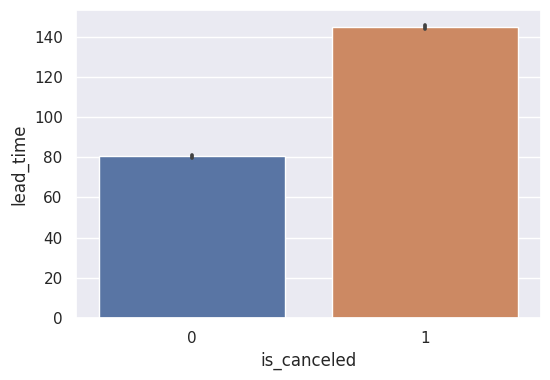

In [651]:
sns.set(rc={"figure.figsize":(6,4)})
sns.barplot(x=df["is_canceled"],y=df["lead_time"])

Our assumption was correct. Higher lead time is leading to higher cancellations.

Similarly, we may also assume that higher number of days in waiting list may also lead to higher cancellations.

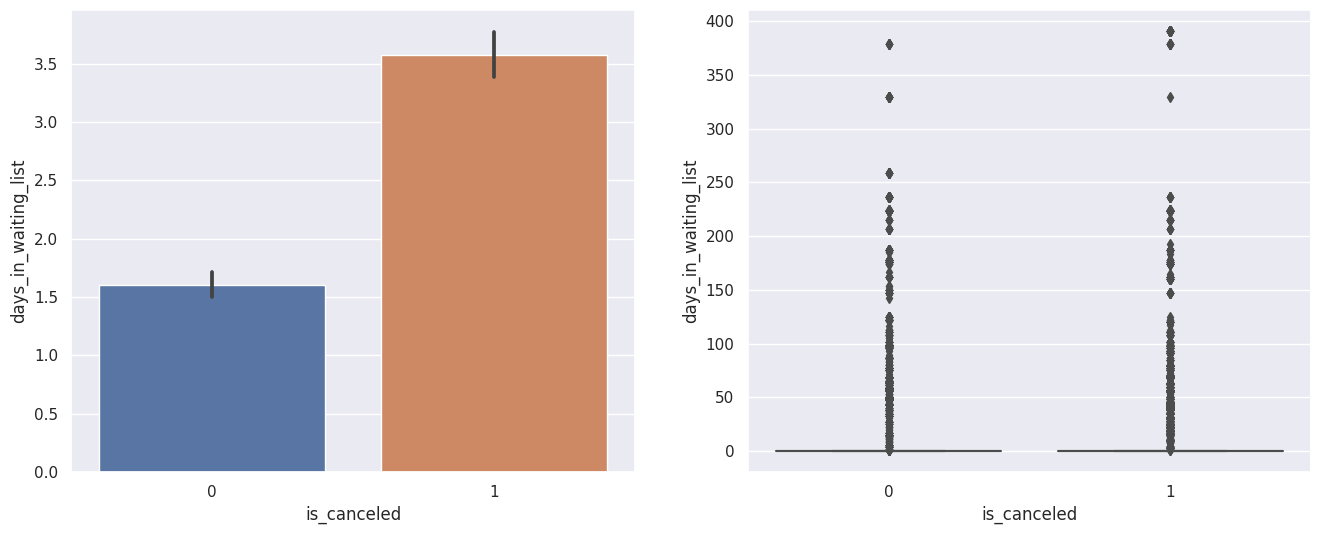

In [652]:
sns.set(rc={"figure.figsize":(16,6)})
f, axes = plt.subplots(1, 2)

sns.barplot(x=df["is_canceled"],y=df["days_in_waiting_list"],ax=axes[0])
sns.boxplot(x=df["is_canceled"],y=df["days_in_waiting_list"],ax=axes[1])

plt.show()

- This assumption is also true. Higher days in waiting list lead to higher cancellations.
- The mean number of days in waiting list is around 3.5 but there are outliers that go up to 400 days in waiting list.

#### We can drop week number column as year, month and day is already given

In [653]:
df = df.drop(columns = ["arrival_date_week_number"])

#### Relationship between month and days in waiting list.

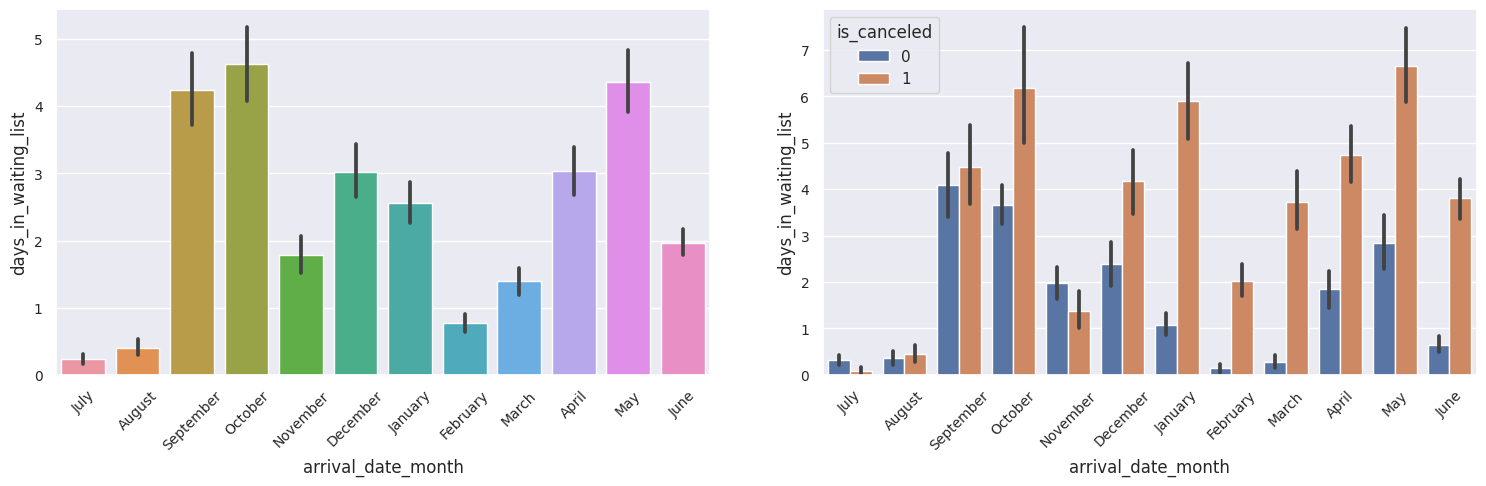

In [654]:
# Set figure size
sns.set(rc={"figure.figsize":(16,6)})
f, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting barplots
sns.barplot(x=df["arrival_date_month"], y=df["days_in_waiting_list"], ax=axes[0])
sns.barplot(x=df["arrival_date_month"], y=df["days_in_waiting_list"], hue=df["is_canceled"], ax=axes[1])

# Adjust font size and rotation of labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)  # Reduce font size of tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)  # Adjust font size of x-axis labels
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)  # Adjust font size of y-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels to prevent overlap

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


- The peak tourist season as per many travel websites is between July and September.

- We can assume that since October is the end of tourist season and May being the beginning of tourist season, the mean number of days in waiting list is high.

- We can also see that despite lesser mean number of days in waiting list in January, February, March and June, the mean days in waiting list for cancellation is very high. This can indicate that if days in waiting list crosses a certain threshold especially during off-season, there is higher tendency of cancellation.



#### Duration and type of stay 

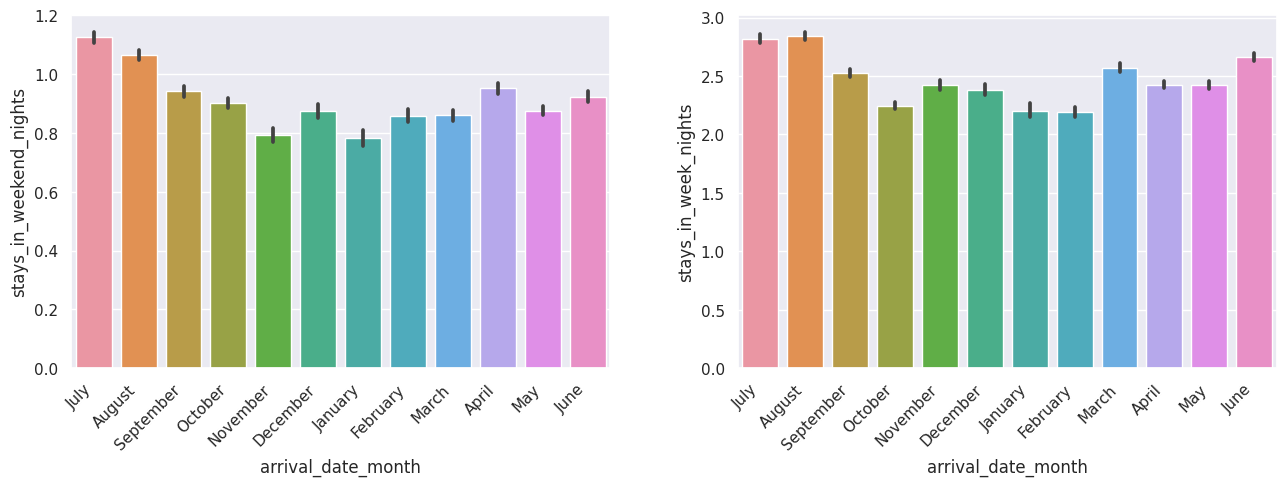

In [655]:
# Set a more appropriate figure size
sns.set(rc={"figure.figsize":(14,6)})  # Adjust width and height to better fit the plots
f, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size

# Plotting barplots
sns.barplot(x=df["arrival_date_month"], y=df["stays_in_weekend_nights"], ax=axes[0])
sns.barplot(x=df["arrival_date_month"], y=df["stays_in_week_nights"], ax=axes[1])

# Rotate x-axis labels to prevent overlap
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate labels and align them to the right

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


The average number of stays in weeknights is more than weekend nights. This is probably because there are more number of weeknights. However, the overall pattern of bookings look similar for both.


We want to see if there is any relation between cancellation and duration of stay during weekends or weeknights.

In [656]:

df["total_stay"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

In [657]:
#Dividing data into different columns based on the duration of stay
df["weekend"] = 0
df["weekday"] = 0
df["full_week"] = 0
df["long_weekend"]=0
df["long_stay"] = 0

row_index = 0

for i in df["stays_in_weekend_nights"]:
    if df["total_stay"][row_index]<7:
        if i==0 and df["stays_in_week_nights"][row_index]>0:
            df["weekday"][row_index] = 1
        if i>0 and df["stays_in_week_nights"][row_index]==0:
            df["weekend"][row_index] = 1
        if i>0 and df["stays_in_week_nights"][row_index]>0:
            df["long_weekend"][row_index] = 1
    if i>0 and df["stays_in_week_nights"][row_index]>0 and df["total_stay"][row_index]==7:
        df["full_week"][row_index] = 1
    
    if df["total_stay"][row_index] >= 7:
        df["long_stay"][row_index] = 1
    row_index = row_index + 1

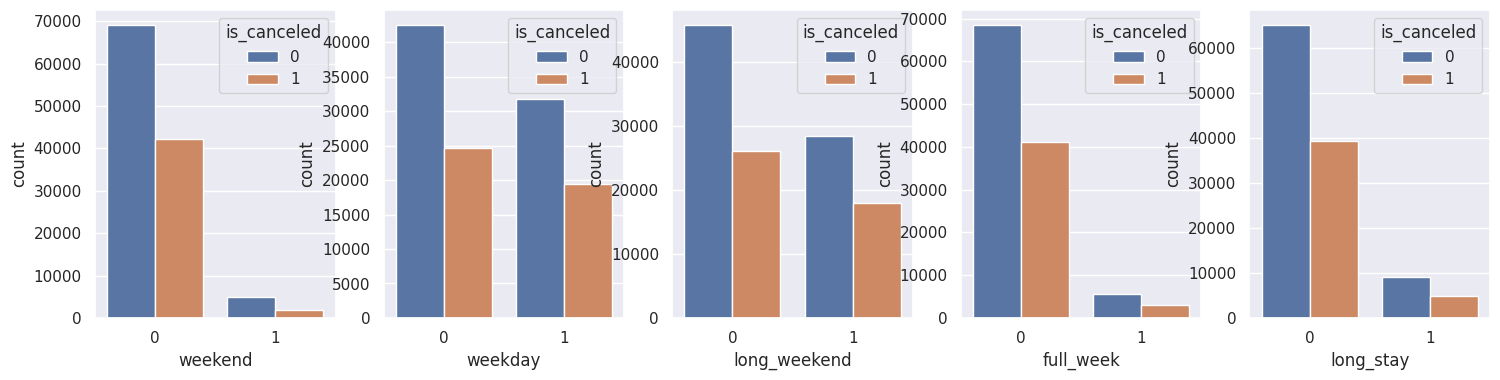

In [658]:
sns.set(rc={"figure.figsize":(18,4)})
f, axes = plt.subplots(1,5)

sns.countplot(x=df["weekend"],hue = df["is_canceled"],ax=axes[0])
sns.countplot(x=df["weekday"],hue = df["is_canceled"],ax=axes[1])
sns.countplot(x=df["long_weekend"],hue = df["is_canceled"],ax=axes[2])
sns.countplot(x=df["full_week"],hue = df["is_canceled"],ax=axes[3])
sns.countplot(x=df["long_stay"],hue = df["is_canceled"],ax=axes[4])

plt.show()

In [659]:
stay_dur = ['weekend','weekday','long_weekend','full_week','long_stay']
for stay in stay_dur:
    perc = df.groupby([stay, 'is_canceled']).size().unstack(1)
    perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
    perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
    print(perc)

is_canceled      0      1  total perc  canc perc
weekend                                         
0            69205  42216    0.941517   0.378887
1             5045   1876    0.058483   0.271059
is_canceled      0      1  total perc  canc perc
weekday                                         
0            42521  24661    0.567694   0.367077
1            31729  19431    0.432306   0.379808
is_canceled       0      1  total perc  canc perc
long_weekend                                     
0             45795  26145    0.607899   0.363428
1             28455  17947    0.392101   0.386772
is_canceled      0      1  total perc  canc perc
full_week                                       
0            68574  41129       0.927   0.374912
1             5676   2963       0.073   0.342980
is_canceled      0      1  total perc  canc perc
long_stay                                       
0            65229  39254     0.88289   0.375697
1             9021   4838     0.11711   0.349087


- We can see that a stay of full week or more has lesser bookings but significant cancellations.

- Only weekend stay is also less common and cancellations are also less.

- But staying on weekdays or weekdays including weekends is more common and the cancellations percentages are also significant.

- We can drop the redundant columns

In [660]:
#Dropping redundant columns related to stay
df = df.drop(columns = ["stays_in_weekend_nights","stays_in_week_nights",'arrival_date_day_of_month'])

#### Country

In [661]:
cnt = dict(df['country'].value_counts(normalize=True))
cnt

{'PRT': 0.40638335779551876,
 'GBR': 0.10248665891795128,
 'FRA': 0.08792812359483834,
 'ESP': 0.0723684768683878,
 'DEU': 0.061687127234472165,
 'ITA': 0.031789529053440686,
 'IRL': 0.02858257896478294,
 'BEL': 0.01969983625889759,
 'BRA': 0.018724176840390603,
 'NLD': 0.017748517421883617,
 'USA': 0.017655193477504688,
 'CHE': 0.014550051328169408,
 'CN': 0.010842545537842859,
 'AUT': 0.010681349633915618,
 'SWE': 0.008619738862635638,
 'CHN': 0.008458542958708397,
 'POL': 0.007737403388507581,
 'ISR': 0.005667308622284061,
 'RUS': 0.005285528849824805,
 'NOR': 0.005132816940841103,
 'ROU': 0.00421654548693889,
 'FIN': 0.003766893754931322,
 'DNK': 0.003648117825721776,
 'AUS': 0.00361418184594762,
 'AGO': 0.0030627221746175838,
 'LUX': 0.00240945456396508,
 'MAR': 0.0021634187106024487,
 'TUR': 0.002095546751054136,
 'HUN': 0.0019343508471268952,
 'ARG': 0.0017986069280302708,
 'JPN': 0.0016713470038771858,
 'CZE': 0.0014507631353451714,
 'IND': 0.001272599241530852,
 'KOR': 0.00111

We can see that top 15 countries cover more than 80% of the data. For ease of exploration and processing, we will only keep the top 15 countries.

In [662]:
df = df[(df["country"]=="PRT") | (df["country"]=="GBR") | (df["country"]=="FRA") |(df["country"]=="ESP") | (df["country"]=="DEU") |
        (df["country"]=="ITA") | (df["country"]=="IRL") | (df["country"]=="BEL") | (df["country"]=="BRA") |
        (df["country"]=="NLD") | (df["country"]=="USA") | (df["country"]=="CHE") | (df["country"]=="CN") |
        (df["country"]=="AUT") | (df["country"]=="SWE")]


#### Market Segment and Customer type

In [663]:
# Dropping undefined values from market segment
row_index = 0
for i in df["market_segment"]:
    if i == "Undefined":
        df = df.drop(row_index)
    row_index = row_index + 1
    
df = df.reset_index()
df = df.drop(columns=["index"])


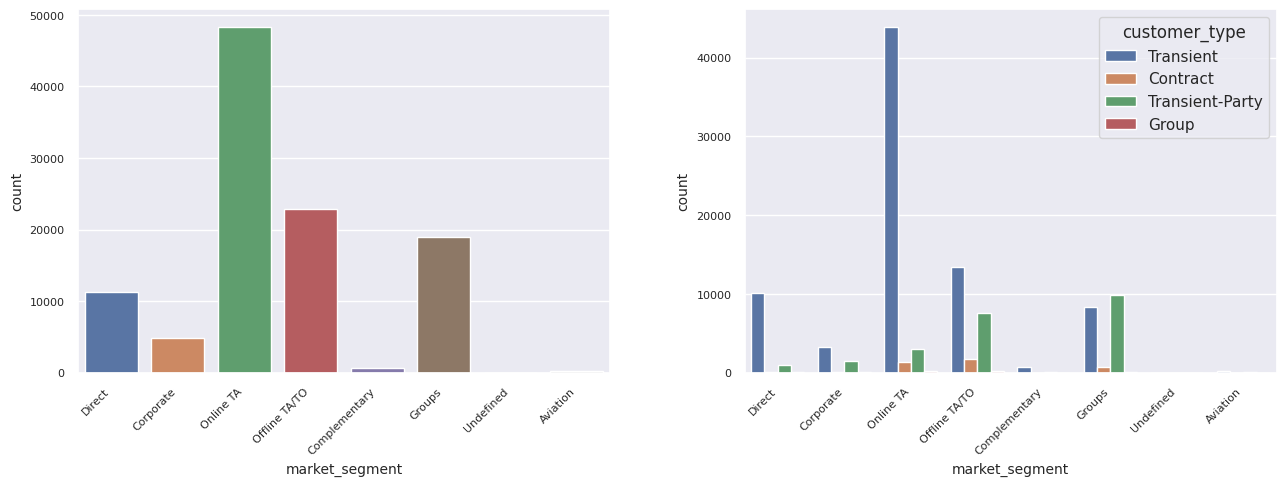

In [664]:
# Set figure size and create subplots
sns.set(rc={"figure.figsize":(14,6)})  # Adjust figure size as needed
f, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting countplots
sns.countplot(x=df["market_segment"], ax=axes[0])
sns.countplot(x=df["market_segment"], hue=df["customer_type"], ax=axes[1])

# Adjust font size of ticks and labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size of tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)  # Reduce font size of x-axis labels
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)  # Reduce font size of y-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


In [665]:
perc = df.groupby(['market_segment', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
print(perc)

is_canceled           0        1  total perc  canc perc
market_segment                                         
Aviation          152.0     50.0    0.001884   0.247525
Complementary     609.0     85.0    0.006472   0.122478
Corporate        3871.0    972.0    0.045165   0.200702
Direct           9518.0   1739.0    0.104981   0.154482
Groups           6886.0  12056.0    0.176650   0.636469
Offline TA/TO   14656.0   8267.0    0.213776   0.360642
Online TA       30831.0  17535.0    0.451053   0.362548
Undefined           NaN      2.0         NaN        NaN


- Under market segment, the highest booking is by Online Travel Agents. However the highest cancellation percentage is with the Groups.



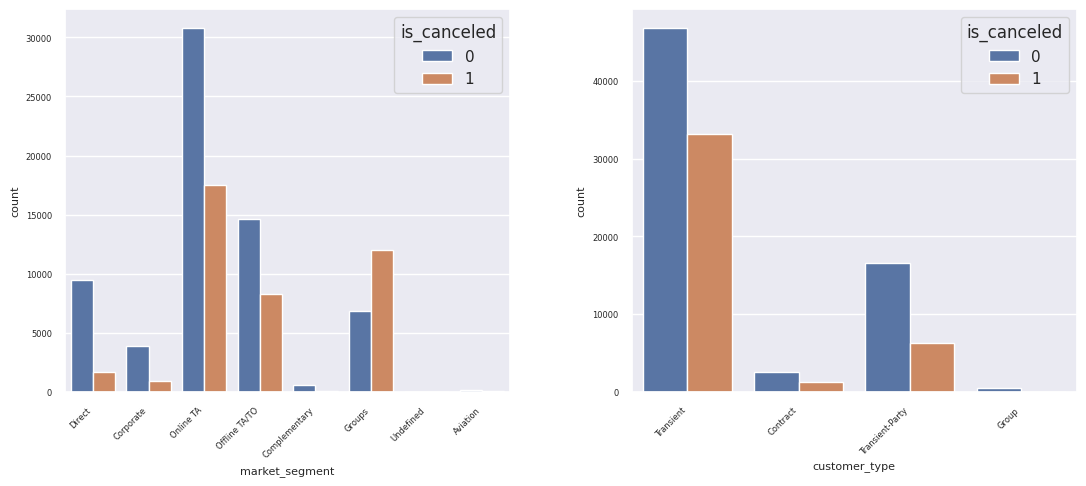

In [666]:
# Adjusting figure size to prevent scrolling
sns.set(rc={"figure.figsize":(12,6)})  # Smaller figure size
f, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust size for two plots side by side

# Plotting countplots
sns.countplot(x=df["market_segment"], hue=df["is_canceled"], ax=axes[0])
sns.countplot(x=df["customer_type"], hue=df["is_canceled"], ax=axes[1])

# Adjust font size and rotate labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=6)  # Reduce font size of tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)  # Reduce font size of x-axis labels
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Reduce font size of y-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=6)  # Rotate x-axis labels and reduce font size

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


In [667]:
perc = df.groupby(['customer_type', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
print(perc)

is_canceled          0      1  total perc  canc perc
customer_type                                       
Contract          2582   1262    0.035849   0.328304
Group              471     58    0.004933   0.109641
Transient        46833  33108    0.745517   0.414155
Transient-Party  16637   6278    0.213702   0.273969


SImilarly, transient customer has the highest cancellation among customer types.

#### Parking space requirement

<Axes: xlabel='required_car_parking_spaces', ylabel='count'>

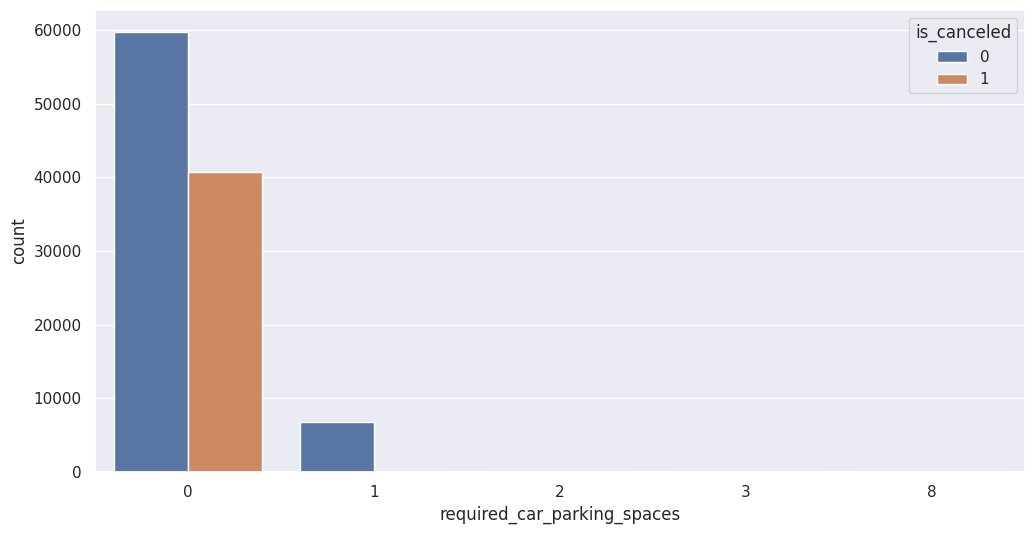

In [668]:
sns.countplot(x=df["required_car_parking_spaces"],hue=df["is_canceled"])

In [669]:
perc = df.groupby(['required_car_parking_spaces', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
print(perc)

is_canceled                        0        1  total perc  canc perc
required_car_parking_spaces                                         
0                            59732.0  40706.0    0.936668   0.405285
1                             6759.0      NaN         NaN        NaN
2                               27.0      NaN         NaN        NaN
3                                3.0      NaN         NaN        NaN
8                                2.0      NaN         NaN        NaN


93% of data belongs to people who did not require parking spaces. All the cancellations belong to this category only. 

#### Room reservation and allotment

We can assume that people who were not assigned the same room that was reserved for them may cancel reservations.
For this, we can take a separate dataset consisting only of data where reserved room type is not same as assigned room type and check.

In [670]:
rooms = df[(df["reserved_room_type"]) != (df["assigned_room_type"])]
rooms_no_change = df[(df["reserved_room_type"]) == (df["assigned_room_type"])]

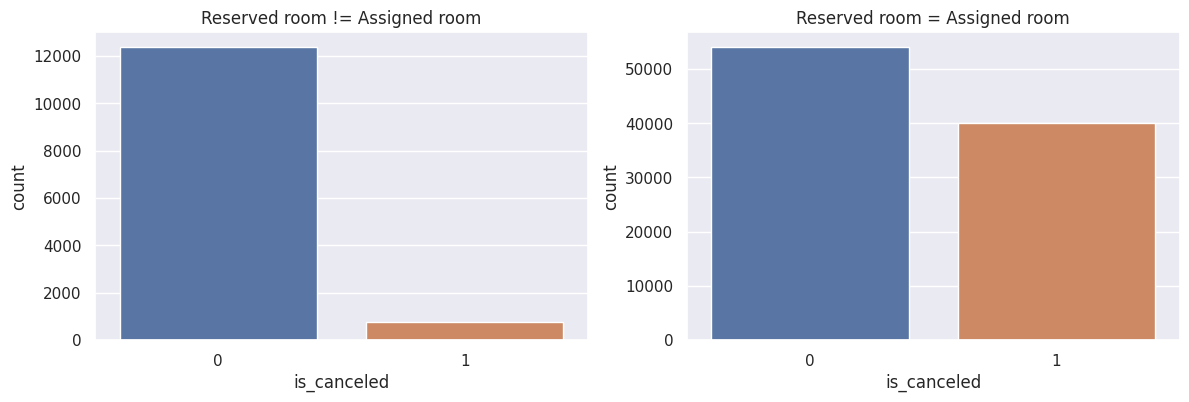

In [671]:
f,axes = plt.subplots(1,2,figsize=(14,4))
sns.countplot(x=rooms["is_canceled"],ax=axes[0]).set(title="Reserved room != Assigned room")
sns.countplot(x=rooms_no_change["is_canceled"],ax=axes[1]).set(title="Reserved room = Assigned room")
plt.show()

We can see that out of the data, the impact on cancellation is marginal even if assigned room is not same as reserved room. However, to reduce redundancy, we can combine it into a single column indicating if there is a change in reserved and assigned room.

Let us also check if assigned room type has any influence on the cancellation

<Axes: xlabel='assigned_room_type', ylabel='count'>

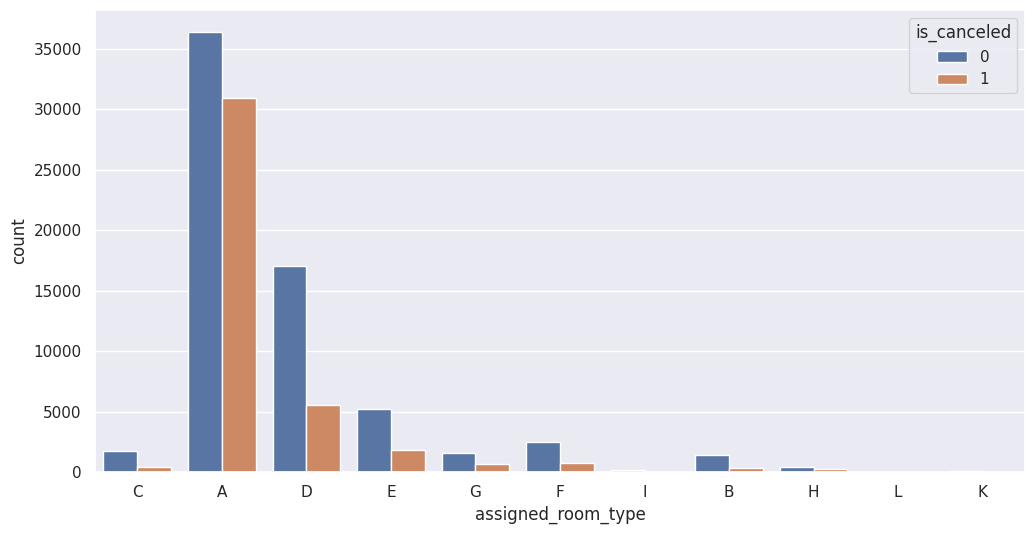

In [672]:
sns.countplot(x=df["assigned_room_type"],hue=df["is_canceled"])

We see that room A and D have majority guests and cancellations are also high. 

#### Checking if change of room has any impact on cancellation

In [673]:
#Adding additional column to see if there is any change of room
df["room_change"] = 0

In [674]:
row_index = 0
for i in df["reserved_room_type"]:
    if i == df["assigned_room_type"][row_index]:
        df["room_change"][row_index] = 0
    else:
        df["room_change"][row_index] = 1
    row_index = row_index + 1
    


In [675]:
df.drop(columns = ["reserved_room_type","assigned_room_type"], inplace=True)

#### Previous cancellations and booking changes

We can assume that people who have made previous cancellations have a higher likelihood to cancel this time. Similarly customers who have not canceled previous bookings will also not cancel this time.

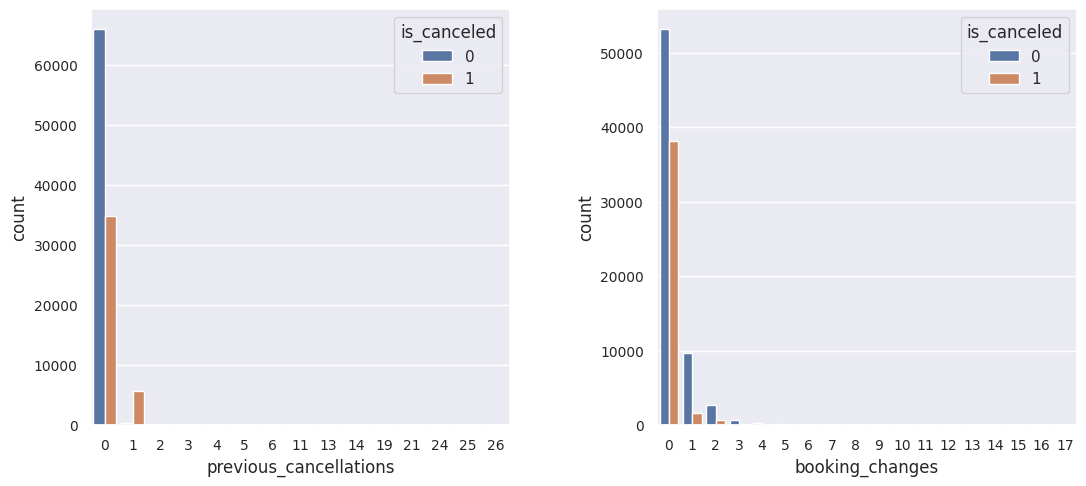

In [676]:
sns.set(rc={"figure.figsize":(12,6)})  # Adjust figure size for better fit
f, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust size for two plots side by side

# Plotting countplots
sns.countplot(x=df["previous_cancellations"], hue=df["is_canceled"], ax=axes[0])
sns.countplot(x=df["booking_changes"], hue=df["is_canceled"], ax=axes[1])

# Adjust font size of ticks and labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust font size of tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)  # Adjust font size of x-axis labels
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)  # Adjust font size of y-axis labels

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


In [677]:
perc = df.groupby(['previous_cancellations', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
print(perc)

is_canceled                   0        1  total perc  canc perc
previous_cancellations                                         
0                       66005.0  34796.0    0.940054   0.345195
1                         320.0   5683.0    0.055983   0.946693
2                          74.0     37.0    0.001035   0.333333
3                          45.0     20.0    0.000606   0.307692
4                          24.0      7.0    0.000289   0.225806
5                          17.0      2.0    0.000177   0.105263
6                          15.0      7.0    0.000205   0.318182
11                         22.0     10.0    0.000298   0.312500
13                          1.0     11.0    0.000112   0.916667
14                          NaN     14.0         NaN        NaN
19                          NaN     19.0         NaN        NaN
21                          NaN      1.0         NaN        NaN
24                          NaN     48.0         NaN        NaN
25                          NaN     25.0

In [678]:
perc = df.groupby(['booking_changes', 'is_canceled']).size().unstack(1)
perc["total perc"] = (perc[0] + perc[1])/len(df["is_canceled"])
perc["canc perc"] = (perc[1]/(perc[0] + perc[1])) 
print(perc)

is_canceled            0        1  total perc  canc perc
booking_changes                                         
0                53159.0  38195.0    0.851952   0.418099
1                 9649.0   1640.0    0.105279   0.145274
2                 2636.0    650.0    0.030645   0.197809
3                  660.0    123.0    0.007302   0.157088
4                  251.0     57.0    0.002872   0.185065
5                   79.0     14.0    0.000867   0.150538
6                   34.0     16.0    0.000466   0.320000
7                   21.0      3.0    0.000224   0.125000
8                   10.0      4.0    0.000131   0.285714
9                    7.0      1.0    0.000075   0.125000
10                   5.0      1.0    0.000056   0.166667
11                   1.0      NaN         NaN        NaN
12                   1.0      NaN         NaN        NaN
13                   5.0      NaN         NaN        NaN
14                   1.0      1.0    0.000019   0.500000
15                   2.0      N

- Here, we can see that cancellation percentage is high where previous cancellation is 1. Hence our first assumption is true.

- However, second assumption has failed. But that is because of the count of data. The column has maximum number of the same value.

#### Relationship with adr  

adr - Average Daily Rate - It can be assumed that rooms with higher adr may be costlier. Hence, the chances of cancellation needs to be examined. As we do not have a feature for room price, we should check the relationship of adr with other factors also.

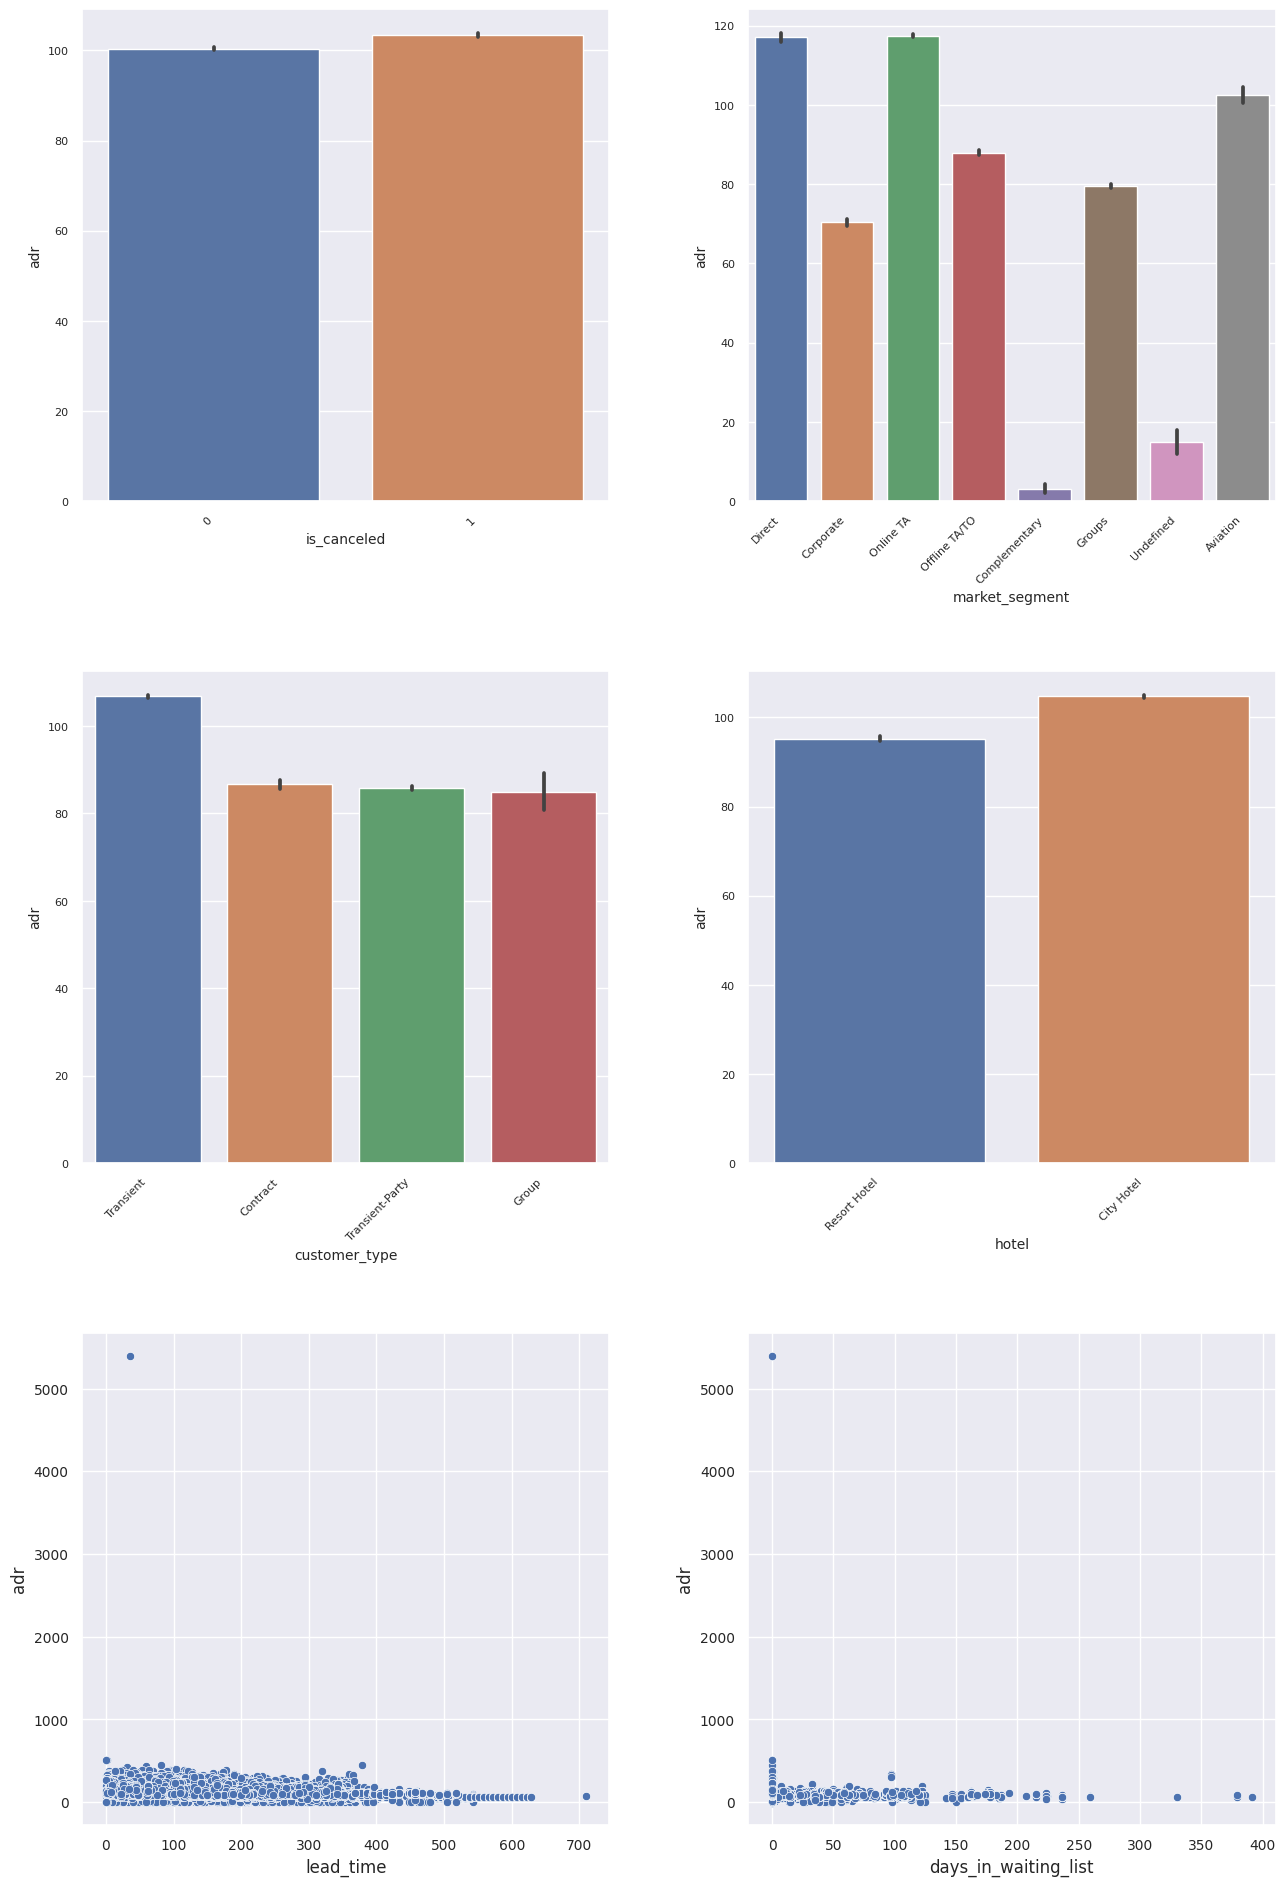

In [679]:
f, axes = plt.subplots(3, 2, figsize=(14, 20))

# Plotting barplots and scatterplots
sns.barplot(x=df["is_canceled"], y=df["adr"], ax=axes[0, 0])
sns.barplot(x=df["market_segment"], y=df["adr"], ax=axes[0, 1])
sns.barplot(x=df["customer_type"], y=df["adr"], ax=axes[1, 0])
sns.barplot(x=df["hotel"], y=df["adr"], ax=axes[1, 1])
sns.scatterplot(x=df["lead_time"], y=df["adr"], ax=axes[2, 0])
sns.scatterplot(x=df["days_in_waiting_list"], y=df["adr"], ax=axes[2, 1])

# Adjust font size and rotate labels for barplots
for ax in axes.flat:
    if ax in [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]:
        ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size of tick labels
        ax.set_xlabel(ax.get_xlabel(), fontsize=10)  # Reduce font size of x-axis labels
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)  # Reduce font size of y-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)  # Rotate and reduce font size of x-axis labels
    else:
        ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust font size of tick labels for scatterplots
        ax.set_xlabel(ax.get_xlabel(), fontsize=12)  # Adjust font size of x-axis labels for scatterplots
        ax.set_ylabel(ax.get_ylabel(), fontsize=12)  # Adjust font size of y-axis labels for scatterplots

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


- The mean adr for cancellation is slightly higher than non-cancellations. 
- Direct and Online TA market segment have higher mean adr. The bookings in these categories are frequent and the likelihood of concessions is low.
- Transient customer type has higher mean adr. As transient customers are more frequent and seek shorter stays, they bring higher revenue.
- City hotels have higher adr.
- It appears that adr decreases as lead time and waiting list duration increases. But because of outliers, the pattern is unclear.

In [680]:
#Outlier treatment for waiting list and lead time columns
df1 = df.copy()
def outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3-Q1
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    return data.clip(upper_bound, lower_bound)
for col in ['adr']:
    df1[col] = outlier(df1[col])

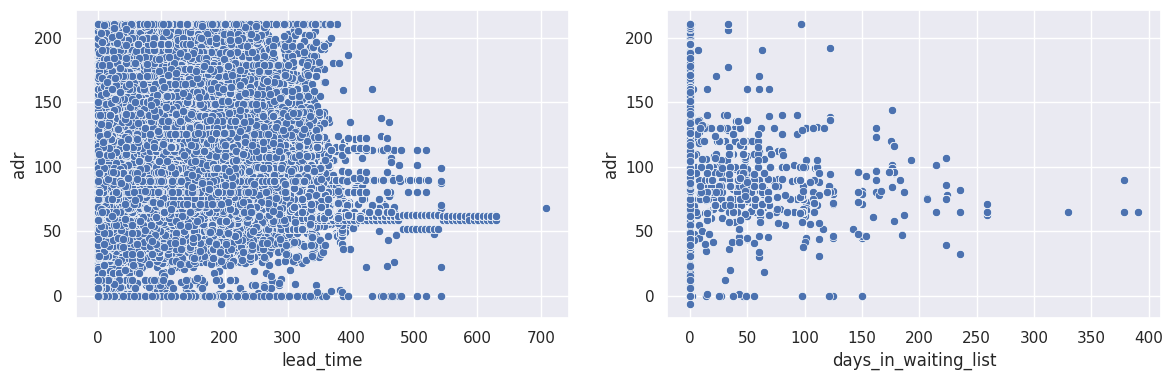

In [681]:
f,axes = plt.subplots(1,2,figsize=(14,4))
sns.scatterplot(x=df1["lead_time"],y=df1["adr"],ax=axes[0])
sns.scatterplot(x=df1["days_in_waiting_list"],y=df1["adr"],ax=axes[1])
plt.show()

There seems to be no relationship between lead time and adr or waiting list and adr after treating outliers. 

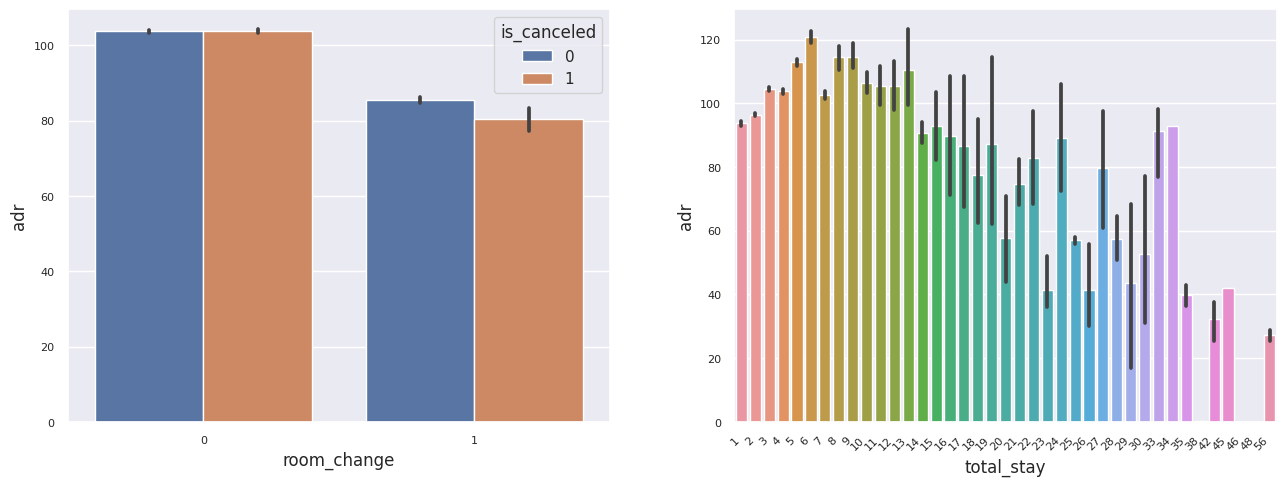

In [682]:
# Set figure size and create subplots
f, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the first barplot
sns.barplot(x=df["room_change"], y=df["adr"], hue=df["is_canceled"], ax=axes[0])
axes[0].tick_params(axis='both', which='major', labelsize=8)  # Further reduce font size of tick labels

# Plotting the second barplot
sns.barplot(x=df["total_stay"], y=df["adr"], ax=axes[1])
axes[1].tick_params(axis='both', which='major', labelsize=8)  # Further reduce font size of tick labels
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=8)  # Rotate and reduce font size of x-axis labels

plt.tight_layout(pad=4.0)  # Adjust spacing between subplots
plt.show()


- Room changes have lower mean adr than no room changes. And cancellation after room changes have even lesser adr. This can indicate that hotels incur a loss due to room changes and further cancellation.  
- As the total stay duration increases, the mean adr increases and then drops with further increase in duration of stay.

In [683]:
#Dropping the remaining records with missing values
df = df.dropna(subset = ["kids"])

df = df.reset_index()
df = df.drop(columns=["index"])

#### Checking the imbalance in data after preliminary preprocessing

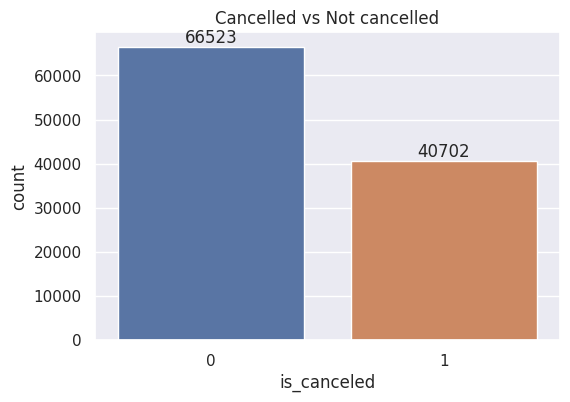

In [684]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x=df["is_canceled"])
for i in ax.containers:
    ax.bar_label(i)
ax.set(title="Cancelled vs Not cancelled")
plt.show()

The distribution remains similar after all the eliminations. We will not consider the data as imbalanced because there is a significant amount of positive class.

#### Correlations

First we encode categorical columns to check correlation and we do this by creating a separate dataset so as not to disturb our original dataset

In [685]:
corr_df = df.copy()

In [686]:
corr_df["month"] = corr_df["arrival_date_month"].map({"January":1,"February":2,"March":3,"April":4,"May":5,"June":6,"July":7,"August":8,
                                       "September":9,"October":10,"November":11,"December":12})
corr_df["year"] = corr_df["arrival_date_year"].astype(str)

corr_df["year"] = corr_df["year"].map({"2015":1,"2016":2,"2017":3})

In [687]:
corr_df = corr_df.drop(columns = ["arrival_date_month","arrival_date_year"])

In [688]:
cat_cols = corr_df.select_dtypes(include='object').columns

In [689]:
#Encoding all categorical columns
from sklearn.preprocessing import LabelEncoder
obj = LabelEncoder()
for i in cat_cols:
    corr_df[i] = obj.fit_transform(corr_df[i])


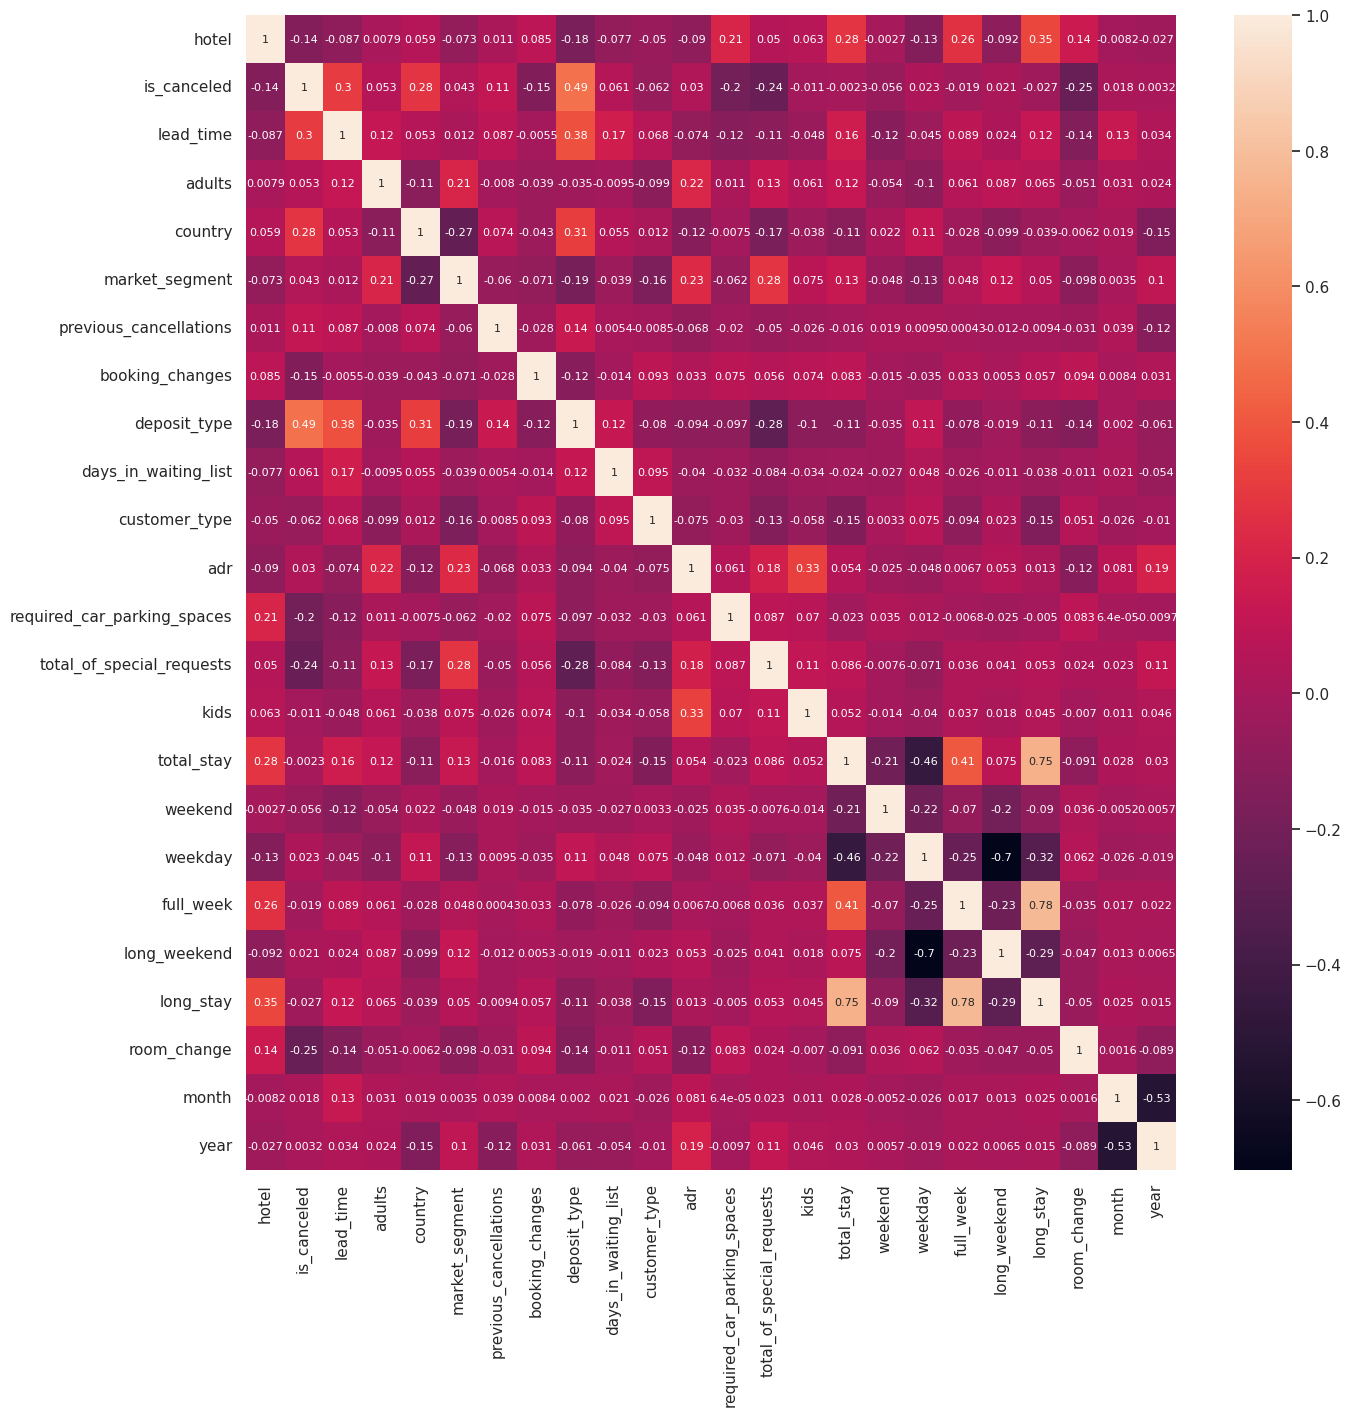

In [690]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_df.corr(), annot=True, annot_kws={"size": 8})  
plt.show()


Two columns have a moderate to high correlation which are total stay, full week and long stay. We will drop the redundant column.

Dropping correlated columns from original dataset

In [691]:
df = df.drop(columns = ["long_stay"])

### Converting categorical columns

Now we need to convert categorical columns into numerical


There are ordinal columns:  Month and year

The rest can be kept as nominal.

In [692]:
from sklearn.preprocessing import LabelEncoder

In [693]:
obj = LabelEncoder()
df["country"] = obj.fit_transform(df["country"])
#df["assigned_room_type"] = obj.fit_transform(df["assigned_room_type"])

In [694]:
#Manual encoding of ordinal column
df["month"] = df["arrival_date_month"].map({"January":1,"February":2,"March":3,"April":4,"May":5,"June":6,"July":7,"August":8,
                                       "September":9,"October":10,"November":11,"December":12})


In [695]:
df["year"] = df["arrival_date_year"].astype(str)

df["year"] = df["year"].map({"2015":1,"2016":2,"2017":3})

In [696]:
df = df.drop(columns = ["arrival_date_month","arrival_date_year"])

In [697]:
dummy_cols = ["hotel","market_segment","deposit_type","customer_type"]

In [698]:
#One-hot encoding
df = pd.get_dummies(df, columns = dummy_cols)

### Standardization and Feature importances

In [699]:
X = df.drop(columns = ["is_canceled"])
y = df["is_canceled"]

In [700]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=23, stratify=y)

In [701]:
#Calculating feature importances
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [702]:
fi=rfc.feature_importances_
xc = X_train.columns

[Text(0.5, 1.0, 'Feature Importances')]

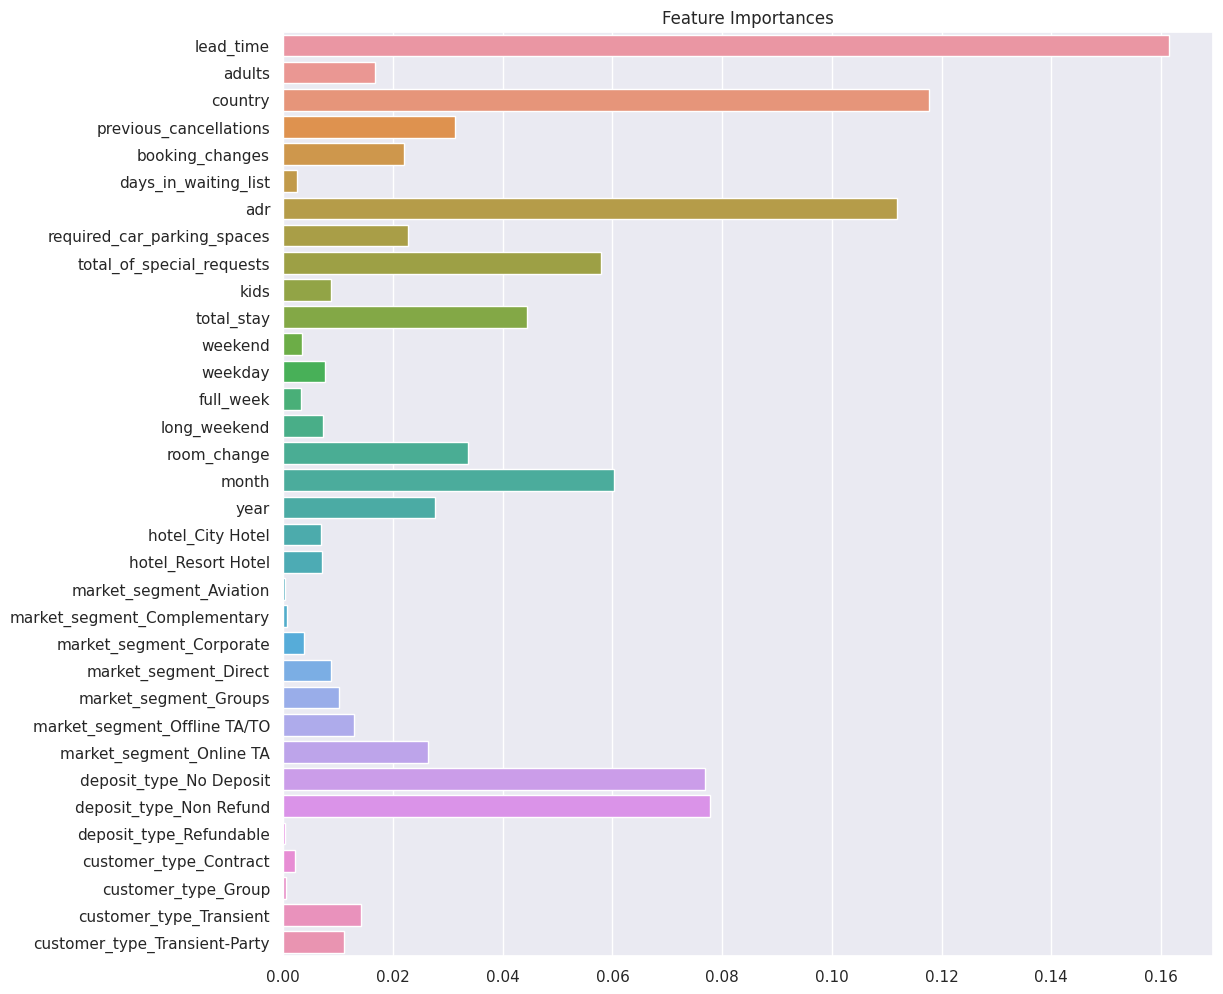

In [703]:
sns.set(rc={"figure.figsize":(12,12)})
sns.barplot(y=xc,x=fi).set(title="Feature Importances")

In [704]:
#Dropping less important features after finding Feature Importances
X = X.drop(columns = ["market_segment_Aviation","market_segment_Complementary","weekend","full_week","days_in_waiting_list",
                       "deposit_type_Refundable","customer_type_Group","customer_type_Contract"
                     ])

In [705]:
#Re-splitting data into train and test sets after dropping less important features
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=41, stratify=y)

### Normalizing Training Data

In [706]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sc = scaler.fit_transform(X_train)

In [707]:
cols = X_train.columns
X_train = pd.DataFrame(sc, columns = cols)

### Training different models one by one and testing their metrics

In [708]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')

from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

In [709]:
model_rfc = rfc.fit(X_train,y_train)
model_lr = lr.fit(X_train,y_train)
model_nb = nb.fit(X_train,y_train)
model_gbc = gbc.fit(X_train,y_train)

### Normalizing Test Data

In [710]:
sc = scaler.transform(X_test)
cols = X_test.columns
X_test = pd.DataFrame(sc, columns = cols)

#### RandomForestClassifier

In [711]:
y_pred_test_rfc = model_rfc.predict(X_test)
y_pred_train_rfc = model_rfc.predict(X_train)

In [712]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(f"Metrics for test set")
result_cm = confusion_matrix(y_test, y_pred_test_rfc)
print(f"Confusion matrix {model_rfc}: \n", result_cm)
result_cr = classification_report(y_test, y_pred_test_rfc)
print(f"Classification Report {model_rfc}: \n", result_cr)
acc_score_rfc = accuracy_score(y_test,y_pred_test_rfc)
print(f"Accuracy Score: for {model_rfc} \n", acc_score_rfc)

print(f"Metrics for training set")
result_cm = confusion_matrix(y_train, y_pred_train_rfc)
print(f"Confusion matrix {model_rfc}: \n", result_cm)
result_cr = classification_report(y_train, y_pred_train_rfc)
print(f"Classification Report {model_rfc}: \n", result_cr)
acc_score = accuracy_score(y_train,y_pred_train_rfc)
print(f"Accuracy Score: for {model_rfc} \n", acc_score)

Metrics for test set
Confusion matrix RandomForestClassifier(): 
 [[18526  1431]
 [ 2163 10048]]
Classification Report RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       0.90      0.93      0.91     19957
           1       0.88      0.82      0.85     12211

    accuracy                           0.89     32168
   macro avg       0.89      0.88      0.88     32168
weighted avg       0.89      0.89      0.89     32168

Accuracy Score: for RandomForestClassifier() 
 0.8882740611788112
Metrics for training set
Confusion matrix RandomForestClassifier(): 
 [[46434   132]
 [  211 28280]]
Classification Report RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46566
           1       1.00      0.99      0.99     28491

    accuracy                           1.00     75057
   macro avg       1.00      0.99      1.00     75057
weighted avg       1.00      1.00    

In [713]:
from sklearn.metrics import roc_auc_score
auc_rfc = np.round(roc_auc_score(y_test,y_pred_test_rfc),3)
auc_rfc

0.876

- For Random Forest Classifier we can see that the test set has an accuracy score of around 88% while the training set has an accuracy score of around 99%. The difference in accuracy score between training and testing set is around 11% which indicates overfitting. 
- The ROC-AUC score is around 87% which is close to the accuracy score of the test set. This means that the model has the ability to classify 87% of the data correctly.


#### Logistic Regression

In [714]:
y_pred_test_lr = model_lr.predict(X_test)
y_pred_train_lr = model_lr.predict(X_train)

In [715]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(f"Metrics for test set")
result_cm = confusion_matrix(y_test, y_pred_test_lr)
print(f"Confusion matrix {model_lr}: \n", result_cm)
result_cr = classification_report(y_test, y_pred_test_lr)
print(f"Classification Report {model_lr}: \n", result_cr)
acc_score_lr = accuracy_score(y_test,y_pred_test_lr)
print(f"Accuracy Score: for {model_lr} \n", acc_score_lr)

print(f"Metrics for training set")
result_cm = confusion_matrix(y_train, y_pred_train_lr)
print(f"Confusion matrix {model_lr}: \n", result_cm)
result_cr = classification_report(y_train, y_pred_train_lr)
print(f"Classification Report {model_lr}: \n", result_cr)
acc_score = accuracy_score(y_train,y_pred_train_lr)
print(f"Accuracy Score: for {model_lr} \n", acc_score)

Metrics for test set
Confusion matrix LogisticRegression(solver='liblinear'): 
 [[18148  1809]
 [ 4627  7584]]
Classification Report LogisticRegression(solver='liblinear'): 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85     19957
           1       0.81      0.62      0.70     12211

    accuracy                           0.80     32168
   macro avg       0.80      0.77      0.78     32168
weighted avg       0.80      0.80      0.79     32168

Accuracy Score: for LogisticRegression(solver='liblinear') 
 0.7999253916936085
Metrics for training set
Confusion matrix LogisticRegression(solver='liblinear'): 
 [[42394  4172]
 [10679 17812]]
Classification Report LogisticRegression(solver='liblinear'): 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85     46566
           1       0.81      0.63      0.71     28491

    accuracy                           0.80     75057
   macro avg       0.

In [716]:
from sklearn.metrics import roc_auc_score
auc_lr = np.round(roc_auc_score(y_test,y_pred_test_lr),3)
auc_lr

0.765

For Logistic Regression 
- Test Accuracy: 80%
- Train Accuracy : 80%
- AUC score : 0.765

#### BernoulliNB

In [717]:
y_pred_test_bnb = model_nb.predict(X_test)
y_pred_train_bnb = model_nb.predict(X_train)

In [718]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(f"Metrics for test set")
result_cm = confusion_matrix(y_test, y_pred_test_bnb)
print(f"Confusion matrix {model_nb}: \n", result_cm)
result_cr = classification_report(y_test, y_pred_test_bnb)
print(f"Classification Report {model_nb}: \n", result_cr)
acc_score_bnb = accuracy_score(y_test,y_pred_test_bnb)
print(f"Accuracy Score: for {model_nb} \n", acc_score_bnb)

print(f"Metrics for training set")
result_cm = confusion_matrix(y_train, y_pred_train_bnb)
print(f"Confusion matrix {model_nb}: \n", result_cm)
result_cr = classification_report(y_train, y_pred_train_bnb)
print(f"Classification Report {model_nb}: \n", result_cr)
acc_score = accuracy_score(y_train,y_pred_train_bnb)
print(f"Accuracy Score: for {model_nb} \n", acc_score)

Metrics for test set
Confusion matrix BernoulliNB(): 
 [[18400  1557]
 [ 5598  6613]]
Classification Report BernoulliNB(): 
               precision    recall  f1-score   support

           0       0.77      0.92      0.84     19957
           1       0.81      0.54      0.65     12211

    accuracy                           0.78     32168
   macro avg       0.79      0.73      0.74     32168
weighted avg       0.78      0.78      0.77     32168

Accuracy Score: for BernoulliNB() 
 0.7775739865705048
Metrics for training set
Confusion matrix BernoulliNB(): 
 [[42862  3704]
 [13009 15482]]
Classification Report BernoulliNB(): 
               precision    recall  f1-score   support

           0       0.77      0.92      0.84     46566
           1       0.81      0.54      0.65     28491

    accuracy                           0.78     75057
   macro avg       0.79      0.73      0.74     75057
weighted avg       0.78      0.78      0.77     75057

Accuracy Score: for BernoulliNB() 
 0

In [719]:
from sklearn.metrics import roc_auc_score
auc_bnb = np.round(roc_auc_score(y_test,y_pred_test_bnb),3)
auc_bnb

0.732

For Bernoulli Naive Bayes model,
- Test Accuracy: 77%
- Train Accuracy : 77%
- AUC score : 0.732

#### Gradient Boosting Classifier

In [720]:
y_pred_test_gbc = model_gbc.predict(X_test)
y_pred_train_gbc = model_gbc.predict(X_train)

In [721]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(f"Metrics for test set")
result_cm = confusion_matrix(y_test, y_pred_test_gbc)
print(f"Confusion matrix {model_gbc}: \n", result_cm)
result_cr = classification_report(y_test, y_pred_test_gbc)
print(f"Classification Report {model_gbc}: \n", result_cr)
acc_score_gbc = accuracy_score(y_test,y_pred_test_gbc)
print(f"Accuracy Score: for {model_gbc} \n", acc_score_gbc)

print(f"Metrics for training set")
result_cm = confusion_matrix(y_train, y_pred_train_gbc)
print(f"Confusion matrix {model_gbc}: \n", result_cm)
result_cr = classification_report(y_train, y_pred_train_gbc)
print(f"Classification Report {model_gbc}: \n", result_cr)
acc_score = accuracy_score(y_train,y_pred_train_gbc)
print(f"Accuracy Score: for {model_gbc} \n", acc_score)

Metrics for test set
Confusion matrix GradientBoostingClassifier(): 
 [[18041  1916]
 [ 2888  9323]]
Classification Report GradientBoostingClassifier(): 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     19957
           1       0.83      0.76      0.80     12211

    accuracy                           0.85     32168
   macro avg       0.85      0.83      0.84     32168
weighted avg       0.85      0.85      0.85     32168

Accuracy Score: for GradientBoostingClassifier() 
 0.8506590400397911
Metrics for training set
Confusion matrix GradientBoostingClassifier(): 
 [[42174  4392]
 [ 6945 21546]]
Classification Report GradientBoostingClassifier(): 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88     46566
           1       0.83      0.76      0.79     28491

    accuracy                           0.85     75057
   macro avg       0.84      0.83      0.84     75057
weighted avg     

In [722]:
from sklearn.metrics import roc_auc_score
auc_gbc = np.round(roc_auc_score(y_test,y_pred_test_gbc),3)
auc_gbc

0.834

For Gradient Boosting Classifier,
- Test Accuracy: 85%
- Train Accuracy : 85%
- AUC score : 0.834

### Visualizing performance of all models

In [723]:
acc = [acc_score_rfc,acc_score_bnb,acc_score_gbc, acc_score_lr]
m = ["Random forest","BernoulliNB","GBC","LogisticReg"]

Text(0.5, 1.0, 'Area Under Curve')

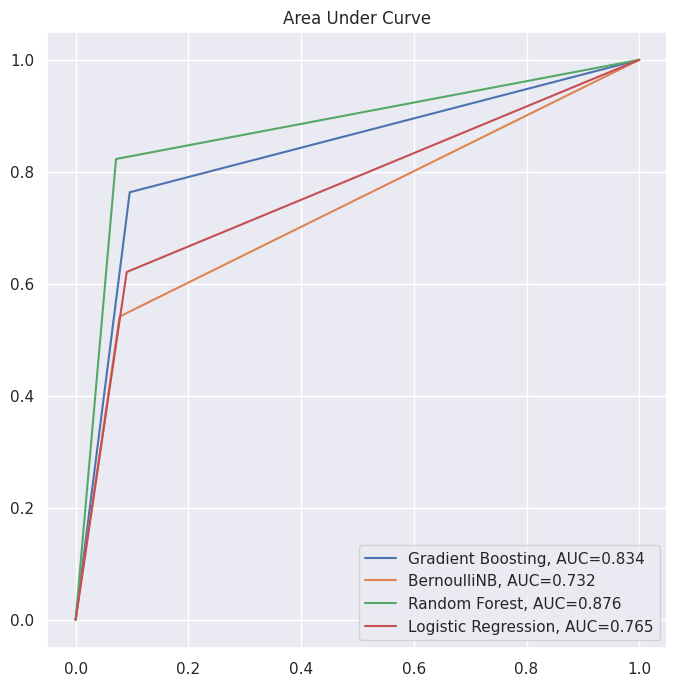

In [724]:
from sklearn import metrics
plt.figure(figsize=(8,8))
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test_gbc)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc_gbc))
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test_bnb)
plt.plot(fpr,tpr,label="BernoulliNB, AUC="+str(auc_bnb))
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test_rfc)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc_rfc))
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test_lr)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc_lr))
plt.legend()
plt.title("Area Under Curve")



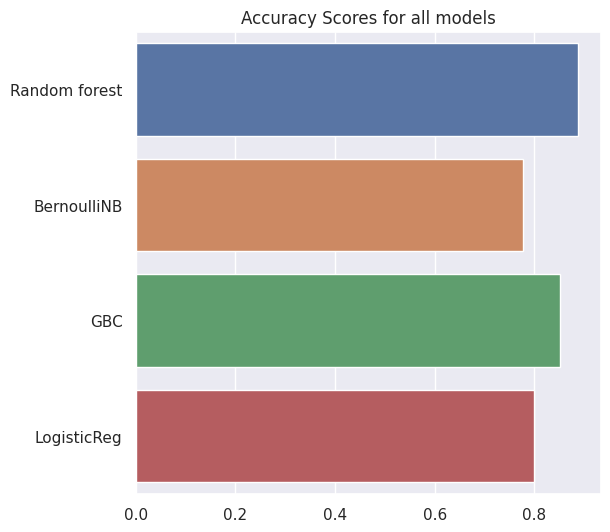

In [725]:
plt.figure(figsize=(6,6))
sns.barplot(x=acc,y=m)
plt.title("Accuracy Scores for all models")
plt.show()

Random Forest Classifier model has highest testing and training accuracies and also AUC score of 0.876. However, there is 11% difference between training and testing accuracy scores.


We choose Random Forest Classifier as it has highest accuracy and AUC score. We will perform K-Fold Cross-validation on training set to get the average training accuracy.

### K-Fold Cross-validation of model

In [726]:
from sklearn.model_selection import cross_val_score

train_scores = cross_val_score(model_rfc,X_train,y_train,cv=10,scoring='accuracy')
test_scores = cross_val_score(model_rfc,X_test,y_test,cv=10,scoring='accuracy')

train_avg = train_scores.mean()
test_avg = test_scores.mean()
   
print(f"Training Average : {train_avg}")
print(f"Training scores : {train_scores}")
print("-"*100)
print(f"Test Average : {test_avg}")
print(f"Test scores : {test_scores}")

Training Average : 0.8856202819223636
Training scores : [0.88462563 0.88915534 0.88169464 0.89155342 0.88569145 0.88489209
 0.88022915 0.88367755 0.8898068  0.88487675]
----------------------------------------------------------------------------------------------------
Test Average : 0.8747510504672782
Test scores : [0.87410631 0.87410631 0.88343177 0.86167237 0.87410631 0.87876904
 0.87783649 0.88218837 0.86629353 0.875     ]


Average performance of Random Forest Classifier model is quite good and it has average accuracy of 87% for test set and 88% for training set. 

### Conclusion

In summary, the Random Forest Classifier yielded the best results for our training, testing, and cross-validation datasets. With an accuracy of 87%, it is likely that the model will classify new, unseen data with an accuracy between 75% and 85%.